In [3]:
import numpy as np
import matplotlib.pyplot as plt

# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording, Trace, Activity, WatchLocation, Path

# For interactive plots, uncomment the following line
# %matplotlib widget
import os
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.fft import fft, fftfreq
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error,accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score


In [4]:
#read data
create_data_pickle = False
if create_data_pickle:
    files = os.listdir('data/train')
    list_of_dicts = []
    types_to_include = ['ax', 'ay', 'az', 'phone_ax', 'phone_ay', 'phone_az', 'speed', 'longitude', 'latitude', 'altitude', 'phone_steps']

    for file in tqdm(files):
        Dict = {}
        d = Recording(os.path.join('data/train',file))

        Dict['labels'] = d.labels
        for data_type in types_to_include:
            if data_type in d.data.keys():
                Dict[data_type] = d.data[data_type]
        list_of_dicts.append(Dict)

    data = pd.DataFrame(list_of_dicts)
    data.to_pickle(path='data/pickled_and_sorted_training_data.pkl.zst', compression={'method': 'zstd'})
else:
    data = pd.read_pickle('data/pickled_and_sorted_training_data.pkl.zst')


In [5]:
#load pickled training 3d norm accelerometer data
import pickle
import pandas as pd

file = open('accel_mag_train.pkl', 'rb')
pickled = pickle.load(file)
accel_mag_train =  pd.DataFrame(((x,) for x in pickled), columns=['lists'])
print(accel_mag_train.shape)
file.close()

labels = []
for label in data["labels"]:
    labels.extend([[label["path_idx"],label["watch_loc"]]])
labels = pd.DataFrame(labels, columns =['path_idx', "smartwatch_location"])
labels



(396, 1)


,path_idx,smartwatch_location
0,2,1
1,0,0
2,0,0
3,2,1
4,1,1
...,...,...
391,3,2
392,4,0
393,2,1
394,3,0


In [6]:
altitude_data = [x.values[::15] for x in data["altitude"]]

In [7]:
dataframe_altitude = pd.DataFrame(altitude_data)

In [8]:
# def features_extraction_watchpos(df, prefix): 
    
#     FEATURES = ['MIN','MAX','MEAN','RMS','VAR','STD','POWER','PEAK','P2P','CREST FACTOR','SKEW','KURTOSIS',
#             'MAX_f','SUM_f','MEAN_f','VAR_f','PEAK_f','SKEW_f','KURTOSIS_f']

#     for idx, feature in enumerate(FEATURES):
#         FEATURES[idx] = FEATURES[idx] + '_' + prefix
    
#     print(FEATURES)
#     Min=[];Max=[];Mean=[];Rms=[];Var=[];Std=[];Power=[];Peak=[];Skew=[];Kurtosis=[];P2p=[];CrestFactor=[];
#     FormFactor=[]; PulseIndicator=[];
#     Max_f=[];Sum_f=[];Mean_f=[];Var_f=[];Peak_f=[];Skew_f=[];Kurtosis_f=[]
    
#     X = df.values
#     ## TIME DOMAIN ##
#     #list of lists of lists, ugly as fuck but it works 
#     for recording in X:
#         Min.append(np.min(recording[0]))
#         Max.append(np.max(recording[0]))
#         Mean.append(np.mean(recording[0]))
#         Rms.append(np.sqrt(np.mean(recording[0]**2)))
#         Var.append(np.var(recording[0]))
#         Std.append(np.std(recording[0]))
#         Power.append(np.mean(recording[0]**2))
#         Peak.append(np.max(np.abs(recording[0])))
#         P2p.append(np.ptp(recording[0]))
#         CrestFactor.append(np.max(np.abs(recording[0]))/np.sqrt(np.mean(recording[0]**2)))
#         Skew.append(stats.skew(recording[0]))
#         Kurtosis.append(stats.kurtosis(recording[0]))
#         FormFactor.append(np.sqrt(np.mean(recording[0]**2))/np.mean(recording[0]))
#         PulseIndicator.append(np.max(np.abs(recording[0]))/np.mean(recording[0]))
#         ## FREQ DOMAIN ##
#         ft = fft(recording[0])
#         S = np.abs(ft**2)/len(df)
#         Max_f.append(np.max(S))
#         Sum_f.append(np.sum(S))
#         Mean_f.append(np.mean(S))
#         Var_f.append(np.var(S))
        
#         Peak_f.append(np.max(np.abs(S)))
#         Skew_f.append(stats.skew(recording[0]))
#         Kurtosis_f.append(stats.kurtosis(recording[0]))

    
#     #Create dataframe from features
#     df_features = pd.DataFrame(index = [FEATURES], 
#                                data = [Min,Max,Mean,Rms,Var,Std,Power,Peak,P2p,CrestFactor,Skew,Kurtosis,
#                                        Max_f,Sum_f,Mean_f,Var_f,Peak_f,Skew_f,Kurtosis_f])
#     return df_features

def features_extraction_common(df, prefix): 
    
    FEATURES = ['Mean', 'STD', 'MAD', 'Var', 'Min', 'Max', 'SMA', 'Energy', 'IQR', 'Entropy', 'Sum_f', 'Max_f', 'Peak_f', 'Peak_i_f', 'Mean_f', 'Skew_f', 'Kurtosis_f', 'Mean_d', 'STD_d', 'MAD_d', 'Var_d', 'Min_d', 'Max_d', 'SMA_d', 'Energy_d', 'IQR_d', 'Entropy_d']

    for idx, feature in enumerate(FEATURES):
        FEATURES[idx] = FEATURES[idx] + '_' + prefix
    
    print(FEATURES)
    Min=[];Max=[];Mean=[];Mad=[];Sma=[];Eng=[];Iqr=[];Entr=[];Std=[];Var=[];
    Min_d=[];Max_d=[];Mean_d=[];Mad_d=[];Sma_d=[];Eng_d=[];Iqr_d=[];Entr_d=[];Std_d=[];Var_d=[];
    Max_f=[];Peak_f=[];Peak_i_f=[];Mean_f=[];Skew_f=[];Kurtosis_f=[];Sum_f=[];
    
    X = df.values
    ## TIME DOMAIN ##
    #list of lists of lists, ugly as fuck but it works 
    for recording in X:
        Mean.append(np.mean(recording[0]))
        Std.append(np.std(recording[0]))
        #median absolute deviation
        Mad.append(stats.median_abs_deviation(recording[0], scale=1))
        Var.append(np.var(recording[0]))
        Min.append(np.min(recording[0]))
        Max.append(np.max(recording[0]))
        #Signal Magnitude Area
        Sma.append(np.sum(recording[0]))
        #energy measure
        Eng.append(np.sum(recording[0]**2)/len(recording[0]))
        Iqr.append(stats.iqr(recording[0]))
        Entr.append(stats.entropy(recording[0]))

        ## FREQ DOMAIN ##
        ft = np.abs(fft(recording[0]))
        Sum_f.append(np.sum(ft))
        Max_f.append(np.max(ft))
        Peak_f.append(np.max((ft)))
        Peak_i_f.append(np.argmax(ft))
        Mean_f.append(np.mean(ft))
        Skew_f.append(stats.skew(ft))
        Kurtosis_f.append(stats.kurtosis(ft))

        #derivative
        f = np.gradient(recording[0])
        Mean_d.append(np.mean(recording[0]))
        Std_d.append(np.std(recording[0]))
        #median absolute deviation
        Mad_d.append(stats.median_abs_deviation(recording[0], scale=1))
        Var_d.append(np.var(recording[0]))
        Min_d.append(np.min(recording[0]))
        Max_d.append(np.max(recording[0]))
        #Signal Magnitude Area
        Sma_d.append(np.sum(recording[0]))
        #energy measure
        Eng_d.append(np.sum(recording[0]**2)/len(recording[0]))
        Iqr_d.append(stats.iqr(recording[0]))
        Entr_d.append(stats.entropy(recording[0]))

    #Create dataframe from features
    df_features = pd.DataFrame(index = [FEATURES], 
                               data = [Mean,Std, Mad, Var, Min, Max, Sma, Eng, Iqr, Entr, Sum_f, Max_f, Peak_f, Peak_i_f, Mean_f, Skew_f, Kurtosis_f, Mean_d ,Std_d, Mad_d, Var_d, Min_d, Max_d, Sma_d, Eng_d, Iqr_d, Entr_d])
    return df_features

# def features_extraction_path(df, prefix): 



In [9]:
#extract features from accelerometer norm and get rid of multiindex
features = pd.DataFrame.transpose(features_extraction_common(accel_mag_train,"acc"))
features.columns = features.columns.map(''.join)
features

['Mean_acc', 'STD_acc', 'MAD_acc', 'Var_acc', 'Min_acc', 'Max_acc', 'SMA_acc', 'Energy_acc', 'IQR_acc', 'Entropy_acc', 'Sum_f_acc', 'Max_f_acc', 'Peak_f_acc', 'Peak_i_f_acc', 'Mean_f_acc', 'Skew_f_acc', 'Kurtosis_f_acc', 'Mean_d_acc', 'STD_d_acc', 'MAD_d_acc', 'Var_d_acc', 'Min_d_acc', 'Max_d_acc', 'SMA_d_acc', 'Energy_d_acc', 'IQR_d_acc', 'Entropy_d_acc']


,Mean_acc,STD_acc,MAD_acc,Var_acc,Min_acc,Max_acc,SMA_acc,Energy_acc,IQR_acc,Entropy_acc,...,Mean_d_acc,STD_d_acc,MAD_d_acc,Var_d_acc,Min_d_acc,Max_d_acc,SMA_d_acc,Energy_d_acc,IQR_d_acc,Entropy_d_acc
0,1.202418,0.212961,0.142390,0.045352,0.153406,2.597480,147175.953766,1.491161,0.285437,11.699222,...,1.202418,0.212961,0.142390,0.045352,0.153406,2.597480,147175.953766,1.491161,0.285437,11.699222
1,1.092686,0.357553,0.279282,0.127844,0.046882,2.826338,128552.271322,1.321806,0.563193,11.621486,...,1.092686,0.357553,0.279282,0.127844,0.046882,2.826338,128552.271322,1.321806,0.563193,11.621486
2,1.093724,0.306151,0.161359,0.093728,0.083755,3.057903,128586.928630,1.289960,0.335081,11.638646,...,1.093724,0.306151,0.161359,0.093728,0.083755,3.057903,128586.928630,1.289960,0.335081,11.638646
3,1.026057,0.349516,0.285567,0.122162,0.276498,2.088655,110551.514205,1.174955,0.572351,11.529345,...,1.026057,0.349516,0.285567,0.122162,0.276498,2.088655,110551.514205,1.174955,0.572351,11.529345
4,1.078819,0.297570,0.135679,0.088548,0.080601,3.464102,82870.587453,1.252399,0.274119,11.214906,...,1.078819,0.297570,0.135679,0.088548,0.080601,3.464102,82870.587453,1.252399,0.274119,11.214906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,1.551828,0.640051,0.320108,0.409665,0.093611,3.464102,180334.844977,2.817836,1.059469,11.582066,...,1.551828,0.640051,0.320108,0.409665,0.093611,3.464102,180334.844977,2.817836,1.059469,11.582066
392,1.468600,0.697000,0.259207,0.485809,0.025811,3.464102,166856.432829,2.642595,0.996380,11.534595,...,1.468600,0.697000,0.259207,0.485809,0.025811,3.464102,166856.432829,2.642595,0.996380,11.534595
393,1.294628,0.596891,0.212268,0.356279,0.034486,3.464102,83519.058875,2.032342,0.552558,10.976953,...,1.294628,0.596891,0.212268,0.356279,0.034486,3.464102,83519.058875,2.032342,0.552558,10.976953
394,0.996864,0.410565,0.255059,0.168563,0.032321,3.464066,133165.093887,1.162301,0.507380,11.719029,...,0.996864,0.410565,0.255059,0.168563,0.032321,3.464066,133165.093887,1.162301,0.507380,11.719029


In [10]:
from scipy.signal import find_peaks

altitude_gradients = []
for sample in altitude_data:
    altitude_gradients.append(np.gradient(sample))

In [26]:
#### Try to make slopes based on not every signal but on every 20th signal or so

In [11]:
altitude_gradients = pd.DataFrame(altitude_gradients)

In [50]:
altitude_data[0][-1]

452.98732080776244

In [12]:
first = []
for i in range(len(altitude_data)):
    first.append(altitude_data[i][0])

last = []
for i in range(len(altitude_data)):
    last.append(altitude_data[i][-1])

In [13]:
pd.DataFrame(first)

,0
0,407.332413
1,407.676311
2,456.399994
3,471.688363
4,457.399994
...,...
391,451.697559
392,436.882629
393,456.395513
394,501.199982


In [23]:
len(altitude_data[0])

489

In [26]:
def pseudo_integration(sample_signals):
    cumulative_norm = np.sum(sample_signals)/len(sample_signals)
    return cumulative_norm

integral_samples = []
for sample in altitude_data:
    integral_samples.append(pseudo_integration(sample))

integral_samples = pd.DataFrame(integral_samples)
integral_samples

,0
0,429.907282
1,426.439195
2,480.132310
3,476.746771
4,479.310266
...,...
391,437.295948
392,425.327961
393,480.062130
394,483.859205


In [99]:
total = pd.concat([features,altitude_gradients,labels["smartwatch_location"]],axis=1)

In [106]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

def split_and_train(X_train,y_train):

    X_train.columns = [''] * len(X_train.columns)
    X_train.fillna(0, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X_train.to_numpy(), y_train.to_numpy(), test_size=0.05, random_state=69)

    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train) 
    #X_test = scaler.fit_transform(X_test) 

    param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

    # Instantiate model with 1000 decision trees, use all cores
    rf = RandomForestClassifier(max_depth=21, random_state=69)

    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5)

    # Fit the random search object to the data
    rand_search.fit(X_train, y_train)

    y_pred = np.round(rand_search.predict(X_test),0)

    print(y_pred)
    return rand_search,y_pred,y_test,X_train,X_test

rf_model,y_pred,y_test,X_train,X_test = split_and_train(total,labels["path_idx"])

[0 4 2 2 0 3 0 2 0 0 1 3 0 1 3 0 4 3 2 1]


In [107]:
print(accuracy_score(y_pred,y_test))

0.5


In [104]:
# Get numerical feature importances
importances = list(rf_model.feature_importances_)
feature_list = ['Mean', 'STD', 'MAD', 'Var', 'Min', 'Max', 'SMA', 'Energy', 'IQR', 'Entropy', 'Sum_f', 'Max_f', 
                'Peak_f', 'Peak_i_f', 'Mean_f', 'Skew_f', 'Kurtosis_f', 'Mean_d', 'STD_d', 'MAD_d', 'Var_d', 'Min_d', 
                'Max_d', 'SMA_d', 'Energy_d', 'IQR_d', 'Entropy_d','slopes']
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Mean                 Importance: 0.0
Variable: STD                  Importance: 0.0
Variable: MAD                  Importance: 0.0
Variable: Var                  Importance: 0.0
Variable: Min                  Importance: 0.0
Variable: Max                  Importance: 0.0
Variable: SMA                  Importance: 0.0
Variable: Energy               Importance: 0.0
Variable: IQR                  Importance: 0.0
Variable: Entropy              Importance: 0.0
Variable: Sum_f                Importance: 0.0
Variable: Max_f                Importance: 0.0
Variable: Peak_f               Importance: 0.0
Variable: Peak_i_f             Importance: 0.0
Variable: Mean_f               Importance: 0.0
Variable: Skew_f               Importance: 0.0
Variable: Kurtosis_f           Importance: 0.0
Variable: Mean_d               Importance: 0.0
Variable: STD_d                Importance: 0.0
Variable: MAD_d                Importance: 0.0
Variable: Var_d                Importance: 0.0
Variable: Min

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Variable Importances')

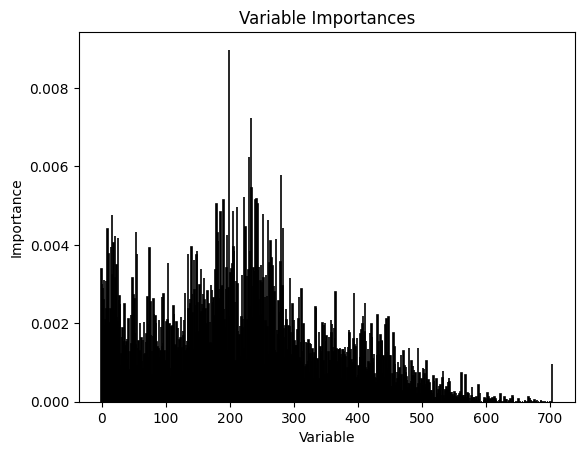

In [105]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')